In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
import torch.nn.functional as F
import scipy.stats as sps
import math

import wandb
import mlflow
from wandb.apis.importers.mlflow import MlflowRun

In [6]:
from samplers import Sampler

sampler = Sampler('Householder_reflection')
sampler.sample(torch.tensor([[3,2]))

ValueError: not enough values to unpack (expected 2, got 1)

In [33]:
def _rotation_matrix(d, num_rotations=None, device='cpu'):
    if num_rotations is None:
        num_rotations = d
    Q = torch.eye(d, device=device)
    # display(Q)
    for _ in range(num_rotations):
        i, j = torch.randint(0, d, (2,), device=device)
        while i == j:
            j = torch.randint(0, d, (1,), device=device)
            j = j.item()
        theta = torch.rand(1, device=device) * 2 * math.pi
        c = torch.cos(theta)
        s = torch.sin(theta)
        col_i = Q[:, i].clone()
        col_j = Q[:, j].clone()
        Q[:, i] = c * col_i - s * col_j
        Q[:, j] = s * col_i + c * col_j

    # if torch.rand(1, device=device) < 0.5:
    #     Q[0, :] = -Q[0, :]
    return Q

norms = []
for _ in range(500):
    d = torch.randint(100, 5000, (1,))
    R = _rotation_matrix(d, 3)
    norms.append(torch.norm(R@R.T - torch.eye(d)))
print(np.average(norms))

6.8020306e-08


In [62]:
import random
def _reflection_matrix(d, device='cpu'):
    Q = torch.eye(d, device=device)
    idx = torch.randint(0, d - 1, (torch.randint(0,d-1, (1,)), ))
    Q[idx, idx] = -1
    return Q

d = 10
print(torch.diag(_reflection_matrix(d)))

tensor([-1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.])


In [63]:
def _householder_matrix(d, device='cpu'):
        
    u = torch.randn(d, device=device)
    H = torch.eye(d) - 2*(u*u.unsqueeze(1))/(u.norm()**2)

    return H

norms = []
for _ in range(500):
    d = torch.randint(100, 5000, (1,))
    R = _householder_matrix(d)
    norms.append(torch.norm(R@R.T - torch.eye(d)))
print(np.average(norms))

2.4918514e-05


In [4]:
import wandb
api = wandb.Api()
run = api.run("zo_peft/zo-bench/tb38gunq")

print(run.summary)


{'_runtime': 39212.356415987015, '_step': 42061, '_timestamp': 1751393739.276904, '_wandb': {'runtime': 39211}, 'accuracy': 0.6442307692307693, 'eval/loss': 0.6357421875, 'eval/runtime': 0.4113, 'eval/samples_per_second': 252.841, 'eval/steps_per_second': 31.605, 'peak_mem': 56.45949840545654, 'step_consumption': 1782.965898513794, 'test/acc': 0.6442307692307693, 'test_acc': 0.6442307692307693, 'test_accuracy': 0.6442307692307693, 'total_flos': 6255515148830245000, 'train/epoch': 2500, 'train/global_step': 20000, 'train/learning_rate': 0, 'train/loss': 0.6522, 'train/peak_mem': 56.45949840545654, 'train/step_consumption': 1782.965898513794, 'train/total_flos': 6255515148830245000, 'train/train_loss': 0.994200105023384, 'train/train_runtime': 39174.1365, 'train/train_samples_per_second': 32.675, 'train/train_steps_per_second': 0.511, 'train/val_acc': 0.33, 'train_loss': 0.994200105023384, 'train_runtime': 39174.1365, 'train_samples_per_second': 32.675, 'train_steps_per_second': 0.511, '

In [8]:
import wandb
api = wandb.Api()
run = api.run("zo_peft/zo-bench/runs/5k2nt4mr")
display(run.history())

,train/val_acc,_step,val_acc,train/train_samples_per_second,test_acc,train/learning_rate,_runtime,accuracy,train/train_loss,_timestamp,...,train/train_runtime,test_accuracy,eval/runtime,train/global_step,train_loss,train/loss,val_accuracy,eval/samples_per_second,test/acc,train/total_flos


In [24]:
api = wandb.Api()
# /zo_peft/zo-bench/runs/5k2nt4mr
entity, project = "zo_peft", "zo-bench"
runs = api.runs(entity + "/" + project)
summary_list, config_list, name_list = [], [], []
attrs = ['q', 'bf16', 'fp16', 'lora', 'mode', 'seed', 'optim', 'lora_r', 'zo_eps', 'zo_tau', 'dropout', 'trainer', 'zo_beta', 'do_train', 'momentum', 'max_steps', 'optimizer', 'task_name', 'adam_beta1', 'adam_beta2', 'eval_steps', 'local_rank', 'lora_alpha', 'model_name', 'hidden_size', 'torch_dtype', 'adam_epsilon', 'load_float16', 'warmup_ratio', 'warmup_steps', 'weight_decay', 'architectures', 'learning_rate', 'load_bfloat16', 'max_grad_norm', 'eval_batch_size', 'train_batch_size', 'zo_use_smoothing', 'lr_scheduler_type', 'num_hidden_layers', 'perturbation_mode', 'num_attention_heads', 'perturbed_module_level', 'coordinate_perturbation', 'train_as_classification', 'module_wise_perturbation']
# attrs = '|'.join(attrs)
# display(attrs)
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if k in attrs })

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list}
)
runs_df.to_csv("project.csv")

In [3]:
loss1 = torch.Tensor([0])
loss2 = torch.Tensor([1])
(loss1 - loss2)

tensor([-1.])

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Процедура

In [ ]:
def generate_rotation_matrix(d, num_rotations=None, device='cpu'):
    if num_rotations is None:
        num_rotations = d

    Q = torch.eye(d, device=device)

    for _ in range(num_rotations):
        i, j = torch.randint(0, d, (2,), device=device)
        while i == j:
            j = torch.randint(0, d, (1,), device=device)
            j = j.item()

        theta = torch.rand(1, device=device) * 2 * math.pi
        c = torch.cos(theta)
        s = torch.sin(theta)

        col_i = Q[:, i].clone()
        col_j = Q[:, j].clone()

        Q[:, i] = c * col_i - s * col_j
        Q[:, j] = s * col_i + c * col_j

    return Q

def generate_reflection_matrix(d, device='cpu'):
    """
    Generates a d x d reflection matrix (identity matrix with -1 at position [0,0]).
    """
    Q = torch.eye(d, device=device)
    Q[0, 0] = -1
    return Q

def generate_orthogonal_matrix(d, num_rotations=None, device='cpu'):
    """
    Generates a random d x d orthogonal matrix.
    With probability 1/2, it is a rotation matrix (det = +1).
    With probability 1/2, it is a rotation matrix multiplied by a reflection (det = -1).
    Complexity: O(d^2) by avoiding matrix multiplications for reflection.
    """
    Q = generate_rotation_matrix(d, device=device)
    if torch.rand(1, device=device) < 0.5:
        Q[0, :] = -Q[0, :]
    return Q

import numpy as np
import scipy.stats as sps

def generate_semi_diagonal(n, m, distribution=sps.norm, device='cpu', dtype=torch.float32):
    """
    Генерирует полудиагональную матрицу размера (n x m) с элементами,
    сгенерированными через scipy.stats, но всё в формате torch.Tensor.

    Параметры:
    n : int
        Количество строк.
    m : int
        Количество столбцов.
    distribution : scipy.stats.rv_continuous, optional
        Распределение для генерации диагональных элементов (по умолчанию стандартное нормальное N(0,1)).
    device : str или torch.device, optional
        Устройство размещения (CPU или GPU).
    dtype : torch.dtype, optional
        Тип данных результирующего тензора.

    Возвращает:
    Sigma : torch.Tensor
        Матрица размера (n, m) с случайными диагональными элементами.
    """
    p = min(n, m)  # Число диагональных элементов

    # Генерация случайных диагональных элементов через scipy.stats
    sigma_np = distribution.rvs(size=p)

    # Перевод в torch.Tensor
    sigma = torch.tensor(sigma_np, device=device, dtype=dtype)

    # Создание нулевой матрицы и заполнение диагонали
    Sigma = torch.zeros((n, m), device=device, dtype=dtype)
    Sigma[torch.arange(p), torch.arange(p)] = sigma

    return Sigma

In [ ]:
def create_random_matrix(n, m, device='cpu'):
    """Создает случайную матрицу в стиле SVD: U @ diag(S) @ V.T"""
    U = generate_rotation_matrix(n)
    V = generate_rotation_matrix(m)

    # S = torch.diag(torch.randn(d, device=device))
    S = generate_semi_diagonal(n, m)

    return U @ S @ V.T

# Ортогональность

In [ ]:
def is_orthogonal(U, tol=1e-4):
    U_np = U.cpu().numpy() if isinstance(U, torch.Tensor) else U
    UtU = U_np.T @ U_np
    I = np.eye(U_np.shape[0])
    diff_norm = np.linalg.norm(UtU - I, ord='fro')
    print(f"Норма ||U^T U - I||_F: {diff_norm:.2e}")
    return diff_norm < tol

In [ ]:
d = 100
U = generate_rotation_matrix(d)

print("Проверка ортогональности матрицы U:")
if is_orthogonal(U, tol=1e-4):
    print("Матрица U ортогональна (в пределах заданной точности).")
else:
    print("Матрица U не ортогональна.")
print(f"Детерминант при этом {np.linalg.det(U):.4f}")

Проверка ортогональности матрицы U:
Норма ||U^T U - I||_F: 8.81e-07
Матрица U ортогональна (в пределах заданной точности).
Детерминант при этом 1.0000


In [ ]:
d = 100
U = generate_orthogonal_matrix(d)

print("Проверка ортогональности матрицы U:")
if is_orthogonal(U, tol=1e-4):
    print("Матрица U ортогональна (в пределах заданной точности).")
else:
    print("Матрица U не ортогональна.")
print(f"Детерминант при этом {np.linalg.det(U):.4f}")

Проверка ортогональности матрицы U:
Норма ||U^T U - I||_F: 6.99e-07
Матрица U ортогональна (в пределах заданной точности).
Детерминант при этом 1.0000


# Нормльность

In [ ]:
d = 5
A = create_random_matrix(d, d)
A

tensor([[ 4.7016e-01,  9.6156e-02,  7.5141e-03, -1.7758e-01,  3.6481e-01],
        [-7.5191e-02,  1.7023e-01, -2.4844e-01,  4.3322e-03,  4.7589e-03],
        [-1.8108e-02,  4.5261e-02,  1.2690e-02, -6.4963e-02,  1.7471e-01],
        [ 1.3853e-04,  4.5755e-01,  3.1121e-01,  4.9697e-04, -1.2844e-01],
        [-1.1924e-01, -6.6904e-02,  1.3106e-01,  1.3672e-01,  7.9985e-02]])

In [ ]:
d = 100
A = create_random_matrix(d, d)
data = A.cpu().flatten().numpy()
# data = sps.norm.rvs(size=1000000)
#data /= np.sum(data)
# data /= np.sum(data)
try:
    shapiro_stat, shapiro_p = sps.shapiro(data)
    print(f"Критерий Шапиро-Уилка: статистика={shapiro_stat:.4f}, p-значение={shapiro_p:.4f}")
    if shapiro_p > 0.05:
        print("не отвергаем H0")
    else:
        print("Выборка не нормальна")
except ValueError as e:
    print("Шапиро-Уилк не применим:", e)

Критерий Шапиро-Уилка: статистика=0.3025, p-значение=0.0000
Выборка не нормальна (отвергаем H0 на уровне значимости 0.05)


Проверка нормировки гистограммы: 1.000


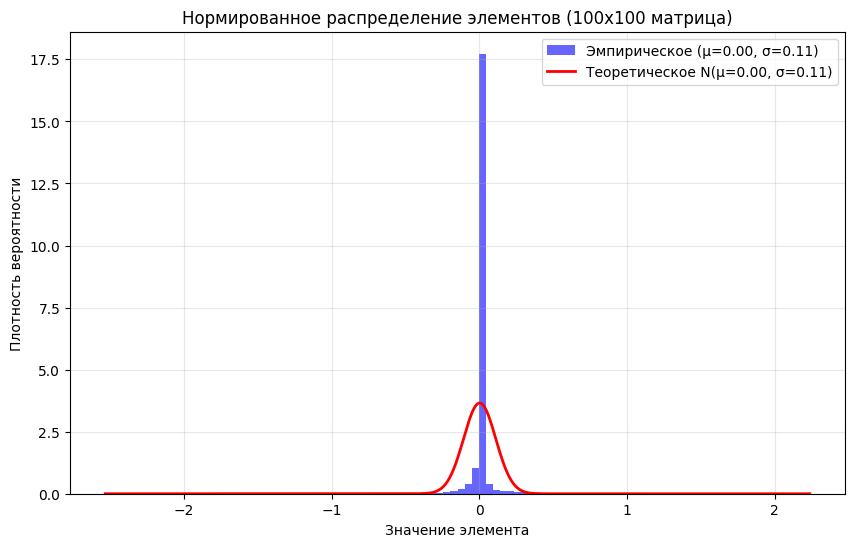

In [ ]:
plt.figure(figsize=(10, 6))

n_bins = 100

plt.hist(data, bins=n_bins, density=True, alpha=0.6, color='blue', label=f'Эмпирическое (μ={np.mean(data):.2f}, σ={np.std(data):.2f})')

x = np.linspace(np.min(data), np.max(data), 1000)
plt.plot(x, norm.pdf(x, loc=np.mean(data), scale=np.std(data)), 'r-', lw=2, label=f'Теоретическое N(μ={np.mean(data):.2f}, σ={np.std(data):.2f})')

plt.title(f"Нормированное распределение элементов ({d}x{d} матрица)")
plt.xlabel('Значение элемента')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.xlim(-0.01, 0.01)

hist, bins = np.histogram(data, bins=n_bins, density=True)
print(f"Проверка нормировки гистограммы: {np.sum(hist * np.diff(bins)):.3f}")

plt.show()

# Время

In [4]:
import time

In [ ]:
d = 1000
start_time = time.time()
A = generate_orthogonal_matrix(d)
end_time = time.time()
hundred_time = end_time - start_time

d = 5000
start_time = time.time()
A = generate_orthogonal_matrix(d)
end_time = time.time()
thousand_time = end_time - start_time

In [ ]:
print(hundred_time, thousand_time)
print(thousand_time / hundred_time)

0.22379517555236816 3.8186769485473633
17.063267512903966


# Замеры времени


In [61]:
def zeropower_via_newtonschulz5(G, steps=5, eps=1e-7):
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G#.bfloat16()
    X /= X.norm() + eps  # ensure top singular value <= 1
    if G.size(0) > G.size(1):
        X = X.T
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
    if G.size(0) > G.size(1):
        X = X.T
    return X

In [48]:
def is_orthogonal(U, tol=1e-4):
    U_np = U.cpu().numpy() if isinstance(U, torch.Tensor) else U
    UtU = U_np.T @ U_np
    I = np.eye(U_np.shape[0])
    diff_norm = np.linalg.norm(UtU - I, ord='fro')
    print(f"Норма ||U^T U - I||_F: {diff_norm:.2e}")
    return diff_norm < tol

In [49]:
def generate_reflection_matrix(d, device='cpu'):
    Q = torch.eye(d, device=device)
    # i = torch.randint(0, d, (1,), device=device).item()
    Q[0, 0] = -1
    return Q

In [50]:
def torch_ortho_rvs(dim: int, device="cpu", dtype=torch.float32):
    z = torch.randn(dim, dim, device=device, dtype=dtype)

    q, r = torch.linalg.qr(z)

    d = torch.diagonal(r, 0)
    ph = d.sign()
    q *= ph.unsqueeze(0)

    return q

In [51]:
def generate_rotation_via_householders(d, device='cpu'):
    v1 = torch.randn(d, device=device)
    v1 /= v1.norm()

    v2 = torch.randn(d, device=device)
    v2 -= (v1 * v2).sum() * v1
    v2 /= v2.norm()

    I = torch.eye(d, device=device)
    H1 = I - 2.0 * v1.unsqueeze(1) @ v1.unsqueeze(0)
    H2 = I - 2.0 * v2.unsqueeze(1) @ v2.unsqueeze(0)
    Q = H2 @ H1
    return Q

In [52]:
def generate_micola_matrix(
    dim,
    num_blocks: int = 10,
    use_PL: bool = True,
    use_P:  bool = True,
    use_PR: bool = True,
    device='cpu',
):
    base = d // num_blocks
    rem  = d %  num_blocks
    blocks = [base + (1 if i < rem else 0) for i in range(num_blocks)]
    block_sizes_L = blocks
    block_sizes_R = blocks


    if block_sizes_L:
        bsL = block_sizes_L
        maxL = max(bsL)
        L_blocks = []
        for b in bsL:
            X = torch.randn(b, b, device=device)
            Qb, Rb = torch.linalg.qr(X)
            sign = torch.sign(torch.diagonal(Rb, 0))
            Qb *= sign
            if torch.det(Qb) < 0:
                Qb[:, 0] *= -1
            L_blocks.append(Qb)
        L = torch.block_diag(*L_blocks).to(device)
    else:
        L = torch.eye(dim, device=device)

    if block_sizes_R:
        bsR = block_sizes_R
        R_blocks = []
        for b in bsR:
            X = torch.randn(b, b, device=device)
            Qb, Rb = torch.linalg.qr(X)
            sign = torch.sign(torch.diagonal(Rb, 0))
            Qb *= sign
            if torch.det(Qb) < 0:
                Qb[:, 0] *= -1
            R_blocks.append(Qb)
        R = torch.block_diag(*R_blocks).to(device)
    else:
        R = torch.eye(dim, device=device)

    idx_PL = torch.randperm(dim, device=device) if use_PL else torch.arange(dim, device=device)
    idx_P  = torch.randperm(dim, device=device) if use_P  else torch.arange(dim, device=device)
    idx_PR = torch.randperm(dim, device=device) if use_PR else torch.arange(dim, device=device)

    M1 = R[:, idx_PR]
    M2 = M1[idx_P, :]
    M3 = L @ M2
    A  = M3[idx_PL, :]

    return A

In [53]:
def generate_micola_matrix_v2(
    dim,
    num_blocks: int = 10,
    use_PL: bool = True,
    use_P:  bool = True,
    use_PR: bool = True,
    device='cpu',
):
    # num_blocks is a variable
    # base*num_blocks = n
    # base = sqrt(n) => num_blocks = n / sqrt(n)
    num_blocks = int(dim // np.sqrt(dim))
    base = dim // num_blocks
    rem  = dim % num_blocks
    blocks = [base + (1 if i < rem else 0) for i in range(num_blocks)]
    block_sizes_L = blocks
    block_sizes_R = blocks


    if block_sizes_L:
        bsL = block_sizes_L
        maxL = max(bsL)
        L_blocks = []
        for b in bsL:
            X = torch.randn(b, b, device=device)
            Qb, Rb = torch.linalg.qr(X)
            sign = torch.sign(torch.diagonal(Rb, 0))
            Qb *= sign
            if torch.det(Qb) < 0:
                Qb[:, 0] *= -1
            L_blocks.append(Qb)
        L = torch.block_diag(*L_blocks).to(device)
    else:
        L = torch.eye(dim, device=device)

    if block_sizes_R:
        bsR = block_sizes_R
        R_blocks = []
        for b in bsR:
            X = torch.randn(b, b, device=device)
            Qb, Rb = torch.linalg.qr(X)
            sign = torch.sign(torch.diagonal(Rb, 0))
            Qb *= sign
            if torch.det(Qb) < 0:
                Qb[:, 0] *= -1
            R_blocks.append(Qb)
        R = torch.block_diag(*R_blocks).to(device)
    else:
        R = torch.eye(dim, device=device)

    idx_PL = torch.randperm(dim, device=device) if use_PL else torch.arange(dim, device=device)
    idx_P  = torch.randperm(dim, device=device) if use_P  else torch.arange(dim, device=device)
    idx_PR = torch.randperm(dim, device=device) if use_PR else torch.arange(dim, device=device)

    M1 = R[:, idx_PR]
    M2 = M1[idx_P, :]
    M3 = L @ M2
    A  = M3[idx_PL, :]

    return A

In [54]:
def generate_housholder_and_reflection_matrix(d, device='cpu'):
    Q = generate_rotation_via_householders(d, device=device)
    if torch.rand(1, device=device) < 0.5:
        Q[0, :] = -Q[0, :]
    return Q

In [55]:
import time
import pandas as pd

In [56]:
d = 5
U = torch.randn(size=(d, d), device=device)
U

tensor([[ 2.3429,  0.1095,  1.3381,  3.4232, -1.4240],
        [-0.0117,  1.3262, -1.0635,  0.0089,  0.2244],
        [-1.3438,  0.7130,  1.9968, -0.3214,  0.1292],
        [-0.0174,  0.0583, -0.5575,  1.2897,  1.3244],
        [-0.6442,  0.6128,  0.2137,  1.0142,  0.5586]], device='cuda:0')

In [57]:
def ort(U):
    U_np = U.cpu().numpy() if isinstance(U, torch.Tensor) else U
    UtU = U_np.T @ U_np
    I = np.eye(U_np.shape[0])
    diff_norm = np.linalg.norm(UtU - I, ord='fro')
    return diff_norm

In [62]:
d = 3000

micola_v2_times = []
micola_times = []
torch_times = []
reflection_times = []
rotation_times = []
basic_roation_times = []
housholder_and_reflection_times = []
ns_times = []

micola_v2_ort = []
micola_ort = []
torch_ort = []
reflection_ort = []
rotation_ort = []
basic_roation_ort = []
housholder_and_reflection_ort = []
ns_ort = []

for _ in range(500):
    
    start_time = time.time()
    U = generate_micola_matrix_v2(d, device=device)
    end_time = time.time()
    micola_v2_times.append(end_time - start_time)
    micola_v2_ort.append(ort(U))
    
    start_time = time.time()
    U = generate_micola_matrix(d, device=device)
    end_time = time.time()
    micola_times.append(end_time - start_time)
    micola_ort.append(ort(U))

    start_time = time.time()
    U = torch_ortho_rvs(d, device=device)
    end_time = time.time()
    torch_times.append(end_time - start_time)
    torch_ort.append(ort(U))

    start_time = time.time()
    U = generate_reflection_matrix(d, device=device)
    end_time = time.time()
    reflection_times.append(end_time - start_time)
    reflection_ort.append(ort(U))

    start_time = time.time()
    U = generate_rotation_via_householders(d, device=device)
    end_time = time.time()
    rotation_times.append(end_time - start_time)
    rotation_ort.append(ort(U))

    start_time = time.time()
    U = generate_housholder_and_reflection_matrix(d, device=device)
    end_time = time.time()
    housholder_and_reflection_times.append(end_time - start_time)
    housholder_and_reflection_ort.append(ort(U))

    U = torch.randn(size=(d, d), device=device)
    start_time = time.time()
    M = zeropower_via_newtonschulz5(U, steps=10)
    end_time = time.time()
    ns_times.append(end_time - start_time)
    ns_ort.append(ort(M))
    
    # start_time = time.time()
    # U = generate_rotation_matrix(d, device=device)
    # end_time = time.time()
    # basic_roation_times.append(end_time - start_time)

In [63]:
df = pd.DataFrame(
    {
        "Micola v2" : [np.array(micola_v2_times).mean(), np.array(micola_v2_ort).mean()],
        "Micola" : [np.array(micola_times).mean(), np.array(micola_ort).mean()],
        "Torch QR" : [np.array(torch_times).mean(), np.array(torch_ort).mean()],
        "Reflection" : [np.array(reflection_times).mean(), np.array(reflection_ort).mean()],
        "Rotation Housholder" : [np.array(rotation_times).mean(), np.array(rotation_ort).mean()],
        "Houshold + Reflection" : [np.array(housholder_and_reflection_times).mean(), np.array(housholder_and_reflection_ort).mean()],
        "Newton-Schultz" : [np.array(ns_times).mean(), np.array(ns_ort).mean()]
        # "Basic Rotation" : [np.array(basic_roation_times).mean()]
    }, index=['Time', 'Diff norm_F']
)

In [64]:
df

,Micola v2,Micola,Torch QR,Reflection,Rotation Housholder,Houshold + Reflection,Newton-Schultz
Time,0.04423,0.035200,0.004012,0.000217,0.000544,0.001839,0.001060
Diff norm_F,0.00004,0.000057,0.000049,0.000000,0.000038,0.000038,20.418725


In [69]:
df.apply(lambda x: x.sum(), axis=0).sort_values()

Reflection                0.000217
Rotation Housholder       0.000581
Houshold + Reflection     0.001877
Torch QR                  0.004061
Micola                    0.035257
Micola v2                 0.044270
Newton-Schultz           20.419785
dtype: float64

Стоит оценивать "разнообразие" как-нибудь?
Чем продвинутые методы (Micola, NS, ...) лучше бейзлайнов (Reflection, Rotation, ...)?

Расчет памяти

In [ ]:
def calculate_memory(bytes_size: int):
    return bytes_size / (1024**3)

In [ ]:
calculate_memory(4 * 10**10)

37.25290298461914

LORA:

ZO SGD: 4.125

ZO ADAMM: 4.132

FO SGD: 5.855

JAGUAR SIGN: 4.128

JAGUAR MUON: 4.132

ZO MUON: 4.130

FT:

ZO SGD: 4.171

ZO ADAMM: 9.046

FO SGD: 12.246

JAGUAR: 6.726

JAGUAR MUON: 5.875

ZO MUON: 4.177

# NS Iterations tests

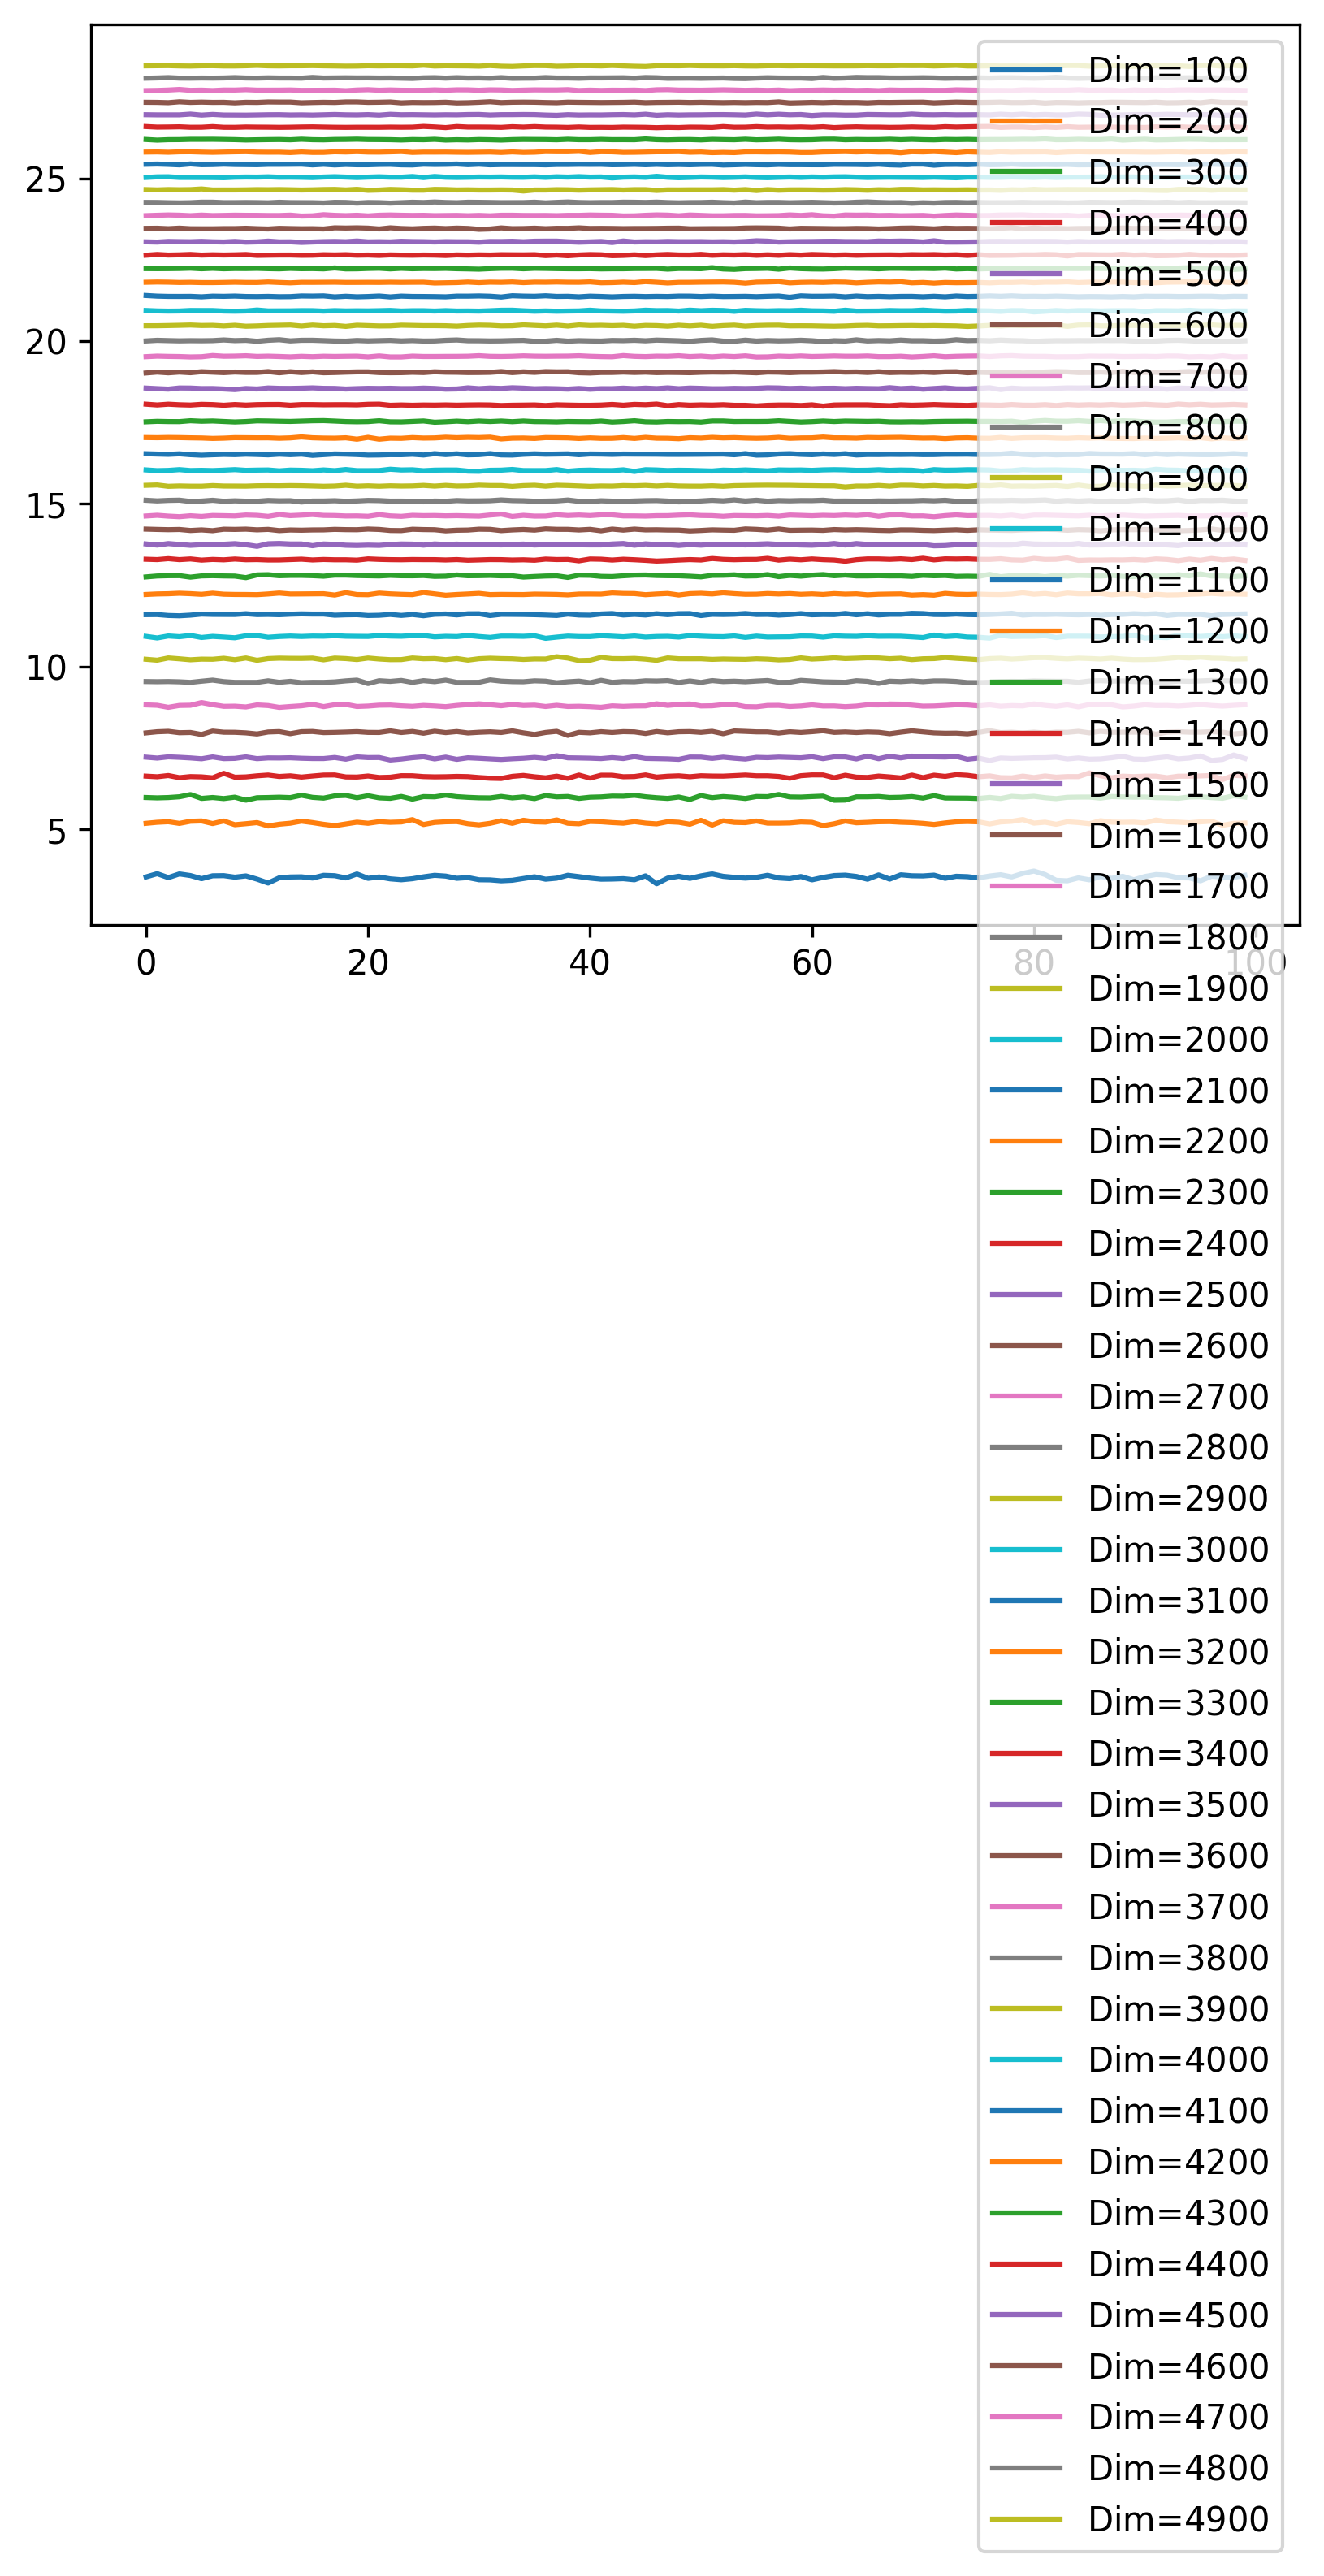

In [70]:
d_max = 5000
trials = 100

plt.figure(dpi=300)

for d in range(100, d_max, 100):
    norms = []
    for _ in range(trials):
        G = torch.randn((d, d))
        X = zeropower_via_newtonschulz5(G)
        norms.append(ort(X))

    plt.plot(norms, label=f'Dim=${d}$')
plt.legend()

In [39]:
def NS_debug(G, steps=100, eps=1e-7):
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750, 2.0315)
    X = G#.bfloat16()
    X /= X.norm() + eps  # ensure top singular value <= 1
    if G.size(0) > G.size(1):
        X = X.T
        
    ns = []
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
        ns.append(ort(X))
        
    if G.size(0) > G.size(1):
        X = X.T
    return X, ns

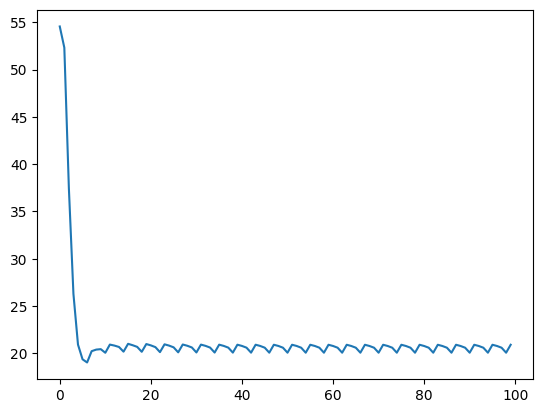

In [40]:
d = 3000
W, N = NS_debug(torch.randn(d, d))
plt.xlabel("NS iteration num")
plt.ylabel("$\Vert X^TX - I \Vert_F$")
plt.plot(N)